# SpikeInterface v0.101.2 - Adapted by Rodrigo Noseda - October 2024

SpikeInterface to analyze a multichannel dataset from Cambridge Neurotech Probes. 
The dataset is extracted using open-ephys DAQ and Bonsai-rx (in .bin).
Event_timestamps need some work.

# 0. Preparation <a class="anchor" id="preparation"></a>

In [1]:
import spikeinterface.full as si
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import os
import csv
import glob
from datetime import datetime
import warnings
warnings.simplefilter("ignore")
%matplotlib widget
print(f"SpikeInterface Version: {si.__version__}")

SpikeInterface Version: 0.101.2


# 1. Load Recording and Paths <a class="anchor" id="loading"></a>

In [2]:
# Setting file paths and basic parameters
base_folder = Path('D:/Ephys_C2DRG/')
data_folder = Path("D:/Ephys_C2DRG/2023_9_19/")
probe_folder = Path("C:/Users/rodri/OneDrive/NosedaLab2/Bonsai2/Repositories/Spikeinterface_RN/spikeinterface/ProbeFiles_RN/")
#Pasted directly from explorer "C:\Users\rodri\Documents\Bonsai-RN\Bonsai_DataRN\2023_3_21\"

recording_paths_list = []
for filename in os.listdir(data_folder):
    if filename.startswith('RawEphysData') and filename.endswith('.bin'):
        recording_paths_list.append(data_folder / filename)
print('Recording Files List:')
print(recording_paths_list)

# parameters associated to the recording in bin format
num_channels = 64 #must know apriori; modify in probe below accordingly.
fs = 30000
gain_to_uV = 0.195
offset_to_uV = 0
rec_dtype = "float32"
time_axis = 0     
time_format = "%H:%M:%S.%f"
n_cpus = os.cpu_count()
n_jobs = n_cpus - 2 #n_jobs = -1 :equal to the number of cores.
job_kwargs = dict(n_jobs=n_jobs, chunk_duration="1s", progress_bar=True)

Recording Files List:
[WindowsPath('D:/Ephys_C2DRG/2023_9_19/RawEphysData_32Ch_ProbeF_Broken_0.bin'), WindowsPath('D:/Ephys_C2DRG/2023_9_19/RawEphysData_32Ch_ProbeF_Broken_1.bin')]


In [3]:
#Extract and append recording segments to Baserecording object
recordings_list = []
rec = si.read_binary(recording_paths_list, num_chan=num_channels,sampling_frequency=fs,
                           dtype=rec_dtype, gain_to_uV=gain_to_uV, offset_to_uV=offset_to_uV, 
                           time_axis=time_axis, is_filtered=False)
recordings_list.append(rec)#Appends all extracted rec to a list. Kilosort does not support segments. Use concatenation.
recording = si.concatenate_recordings(recordings_list)#Creates Object ConcatenateSegmentRecording
#Filtering recording
recording_f = si.bandpass_filter(recording, freq_min=400, freq_max=5000)
recording_cmr = si.common_reference(recording_f, reference='global', operator='median')
#recording_w = si.whiten(recording_cmr, int_scale=200)
#recording_ps = si.phase_shift() #important for Neuropixel
#recording_layers = dict(common=recording_cmr,
#                        whiten=recording_w)
#recording_w

ProbeInterface version: 0.2.24


(-75.0, 320.0)

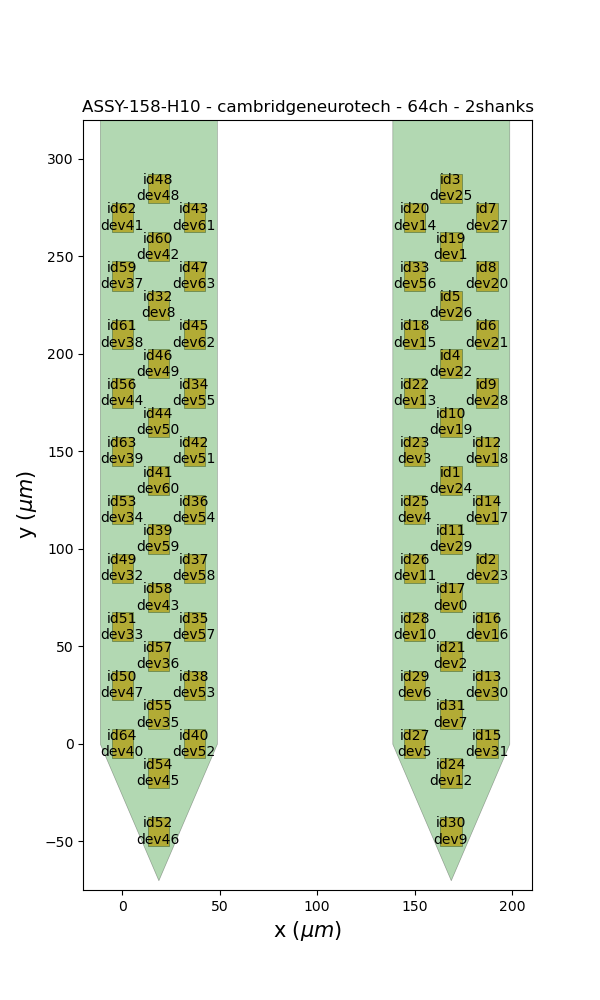

In [7]:
#Get probe from library and set channel mapping
import probeinterface as pi
from probeinterface import Probe
from probeinterface.plotting import plot_probe
print(f"ProbeInterface version: {pi.__version__}")
manufacturer = 'cambridgeneurotech'
probe_name = 'ASSY-158-H10' #probe_name = 'ASSY-158-F' #probe_name = 'ASSY-158-H6'
probeH10 = pi.get_probe(manufacturer, probe_name)#library: comes with contact_ids and shank_ids info.

#Mapping Intan (device) channels
device_channel_indices = [24,23,25,22,26,21,27,20,28,19,29,18,30,17,31,16,0,15,1,14,2,13,3,12,4,11,5,10,6,9,7,8,
    56,55,57,54,58,53,59,52,60,51,61,50,62,49,63,48,32,47,33,46,34,45,35,44,36,43,37,42,38,41,39,40] #Modify accordingly.
#   88,87,89,86,90,85,91,84,92,83,93,82,94,81,95,80,64,79,65,78,66,77,67,76,68,75,69,74,70,73,71,72,
#   120,119,121,118,122,117,123,116,124,115,125,114,126,113,127,112,96,111,97,110,98,109,99,108,100,107,101,106,102,105,103,104]
#Setting Intan channels to probe(RHD-2132/2164)
probeH10.set_device_channel_indices(device_channel_indices)
fig, ax = plt.subplots(figsize=(6, 10))
plot_probe(probeH10, ax=ax, with_contact_id=True, with_device_index=True)
ax.set_xlim(-20, 210)
ax.set_ylim(-75, 320)

In [8]:
#Set probe and group by shank before sorting
recording_clean_prb = recording_cmr.set_probe(probeH10, group_mode="by_shank")
recordings_by_group = recording_clean_prb.split_by("group")
recording_to_process = recordings_by_group[0]

Motion correction:
https://spikeinterface.readthedocs.io/en/stable/how_to/handle_drift.html

In [26]:
#preset_params_ks = si.get_motion_parameters_preset("kilosort_like")
preset_params_nra = si.get_motion_parameters_preset("nonrigid_accurate")
preset = "nonrigid_accurate"
preset_params_nra = ({'direction': 'y',
  'rigid': False,
  'win_shape': 'rect',
  'win_step_um': 100.0,
  'win_scale_um': 100.0,
  'win_margin_um': None,
  'method': 'dredge_ap'})
preset_params_nra

{'direction': 'y',
 'rigid': False,
 'win_shape': 'rect',
 'win_step_um': 100.0,
 'win_scale_um': 100.0,
 'win_margin_um': None,
 'method': 'dredge_ap'}

In [27]:
print("Computing with", preset)
folder = data_folder / "motion_folder_dataset" / preset
recording_corrected, motion, motion_info = si.correct_motion(recording_to_process, preset=preset, folder=folder, output_motion=True, 
                                                                 output_motion_info=True, estimate_motion_kwargs=preset_params_nra, **job_kwargs)

Computing with nonrigid_accurate


detect and localize:   0%|          | 0/6671 [00:00<?, ?it/s]

Cross correlation:   0%|          | 0/3 [00:00<?, ?it/s]

Solve:   0%|          | 0/2 [00:00<?, ?it/s]

'C:\Users\rodri\AppData\Roaming\Python\Python311\Scripts' which is not on PATH.
  Consider adding this directory to PATH

Text(0.5, 0.98, "preset='nonrigid_accurate'")

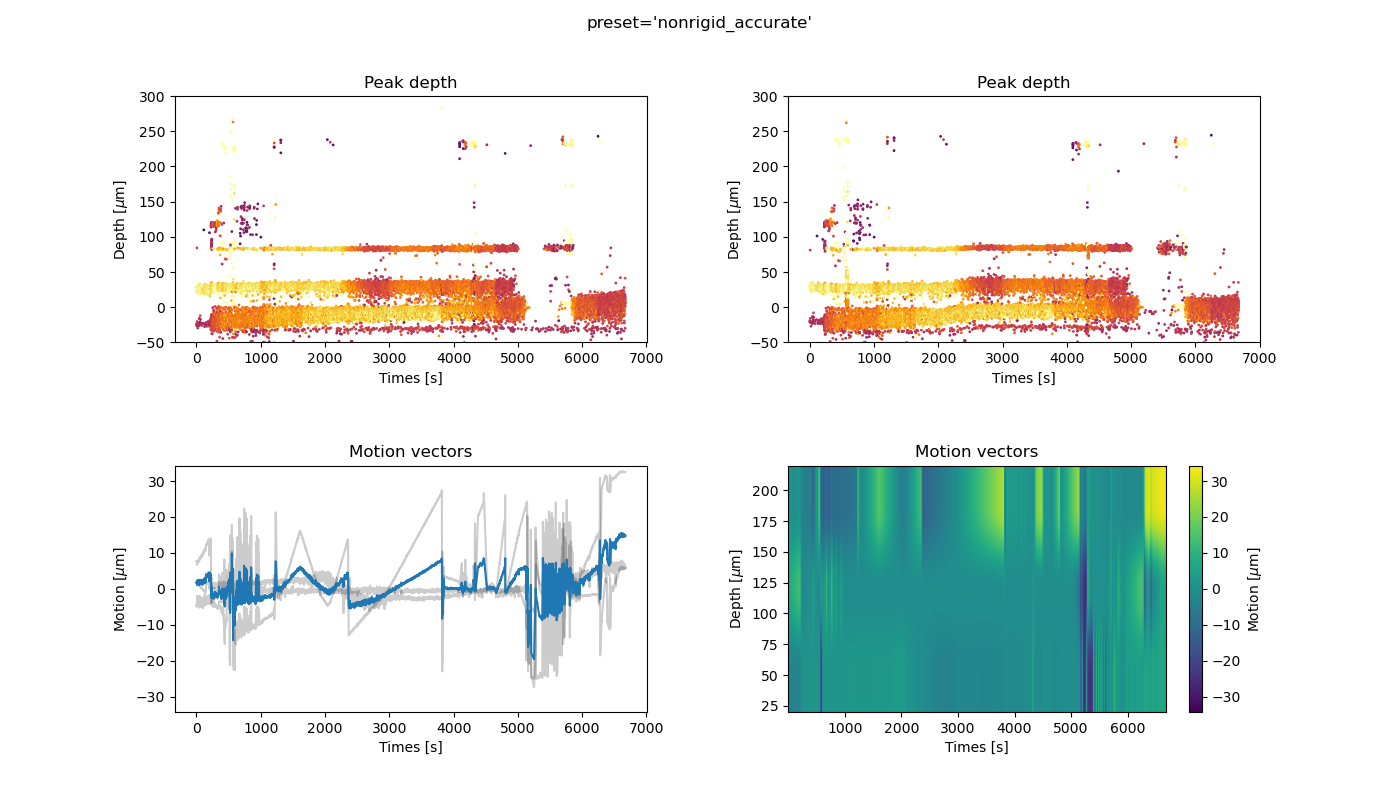

In [28]:
folder = data_folder / "motion_folder_dataset" / preset
motion_info = si.load_motion_info(folder)

# and plot
fig = plt.figure(figsize=(14, 8))
si.plot_motion_info(motion_info, recording_to_process,
        figure=fig,
        depth_lim=(-50, 300),
        color_amplitude=True,
        amplitude_cmap="inferno",
        scatter_decimate=10,
    )
fig.suptitle(f"{preset=}")

Text(0.5, 0.98, "preset='nonrigid_accurate'")

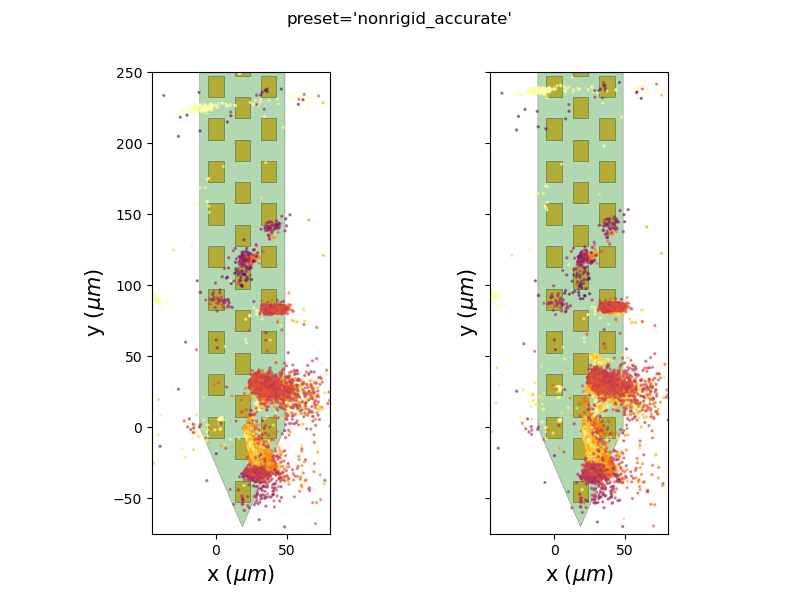

In [41]:
from spikeinterface.sortingcomponents.motion import correct_motion_on_peaks

folder = data_folder / "motion_folder_dataset" / preset
motion_info = si.load_motion_info(folder)
motion = motion_info["motion"]

fig, axs = plt.subplots(ncols=2, figsize=(8, 6), sharey=True)
ax = axs[0]
si.plot_probe_map(recording_to_process, ax=ax)
peaks = motion_info["peaks"]
sr = rec.get_sampling_frequency()
time_lim0 = 0.0
time_lim1 = 3000.0
mask = (peaks["sample_index"] > int(sr * time_lim0)) & (peaks["sample_index"] < int(sr * time_lim1))
sl = slice(None, None, 5)
amps = np.abs(peaks["amplitude"][mask][sl])
amps /= np.quantile(amps, 0.95)
c = plt.get_cmap("inferno")(amps)

color_kargs = dict(alpha=0.5, s=2, c=c)

peak_locations = motion_info["peak_locations"]
ax.scatter(peak_locations["x"][mask][sl], peak_locations["y"][mask][sl], **color_kargs)
ax.set_ylim(-75, 250)
ax.set_xlim(-45, 80)

peak_locations2 = correct_motion_on_peaks(peaks, peak_locations, motion,rec)
ax = axs[1]
si.plot_probe_map(recording_to_process, ax=ax)
ax.scatter(peak_locations2["x"][mask][sl], peak_locations2["y"][mask][sl], **color_kargs)
ax.set_ylim(-75, 250)
ax.set_xlim(-45, 80)
fig.suptitle(f"{preset=}")

In [ ]:
w = si.plot_traces(recording_layers, time_range=[518, 519], channel_ids=[8, 42, 45],
                return_scaled=True, show_channel_ids=True, backend="ipywidgets")

# 2. Preprocessing: Artifact Removal <a class="anchor" id="preprocessing"></a>

In [ ]:
# Function to calculate time difference in seconds
def time_difference_in_seconds(start_time, end_time):
    start = datetime.combine(datetime.min, start_time)
    end = datetime.combine(datetime.min, end_time)
    return (end - start).total_seconds()

# Load the Timestamps CSV files, extract start time
timestamp_start_df = pd.read_csv(data_folder / 'TimestampsEphys_0.csv', nrows=1, header=None, names=['Timestamps'])
timestamp_start = pd.to_datetime(timestamp_start_df['Timestamps'][0]).time() # Convert timestamps to datetime objects (only time part)

#Load times from timestamps csv files and calculate start time in seconds.
tms_files = sorted(glob.glob(os.path.join(data_folder, "Timestamps*.csv")))
concatenated_segment_times = pd.DataFrame()
for tms_file in tms_files:
    tms_df = pd.read_csv(tms_file, header=None)#, names=['Start_Times', 'End_Times'])#(usecols=[0], nrows=1)
    segment_times = pd.DataFrame({'Start_Times': tms_df.iloc[0], 'End_Times': tms_df.iloc[-1]})
    concatenated_segment_times = pd.concat([concatenated_segment_times, segment_times], ignore_index=True)
concatenated_segment_times['Start_Times'] = pd.to_datetime(concatenated_segment_times['Start_Times']).dt.time # Convert the tms timestamps to timedelta (ignoring date)
concatenated_segment_times['End_Times'] = pd.to_datetime(concatenated_segment_times['End_Times']).dt.time # Convert the tms timestamps to timedelta (ignoring date)
#concatenated_segment_times['Segment_Times'] = pd.to_datetime(concatenated_segment_times['Segment_Times']).dt.time # Convert the tms timestamps to timedelta (ignoring date)
# Apply the time difference function to each row in the tms DataFrame
concatenated_segment_times['Start_Times_seconds'] = concatenated_segment_times['Start_Times'].apply(lambda x: time_difference_in_seconds(timestamp_start, x))
concatenated_segment_times['End_Times_seconds'] = concatenated_segment_times['End_Times'].apply(lambda x: time_difference_in_seconds(timestamp_start, x))
concatenated_segment_times['Segment_duration_seconds'] = concatenated_segment_times['End_Times_seconds'] - concatenated_segment_times['Start_Times_seconds']
#print(concatenated_segment_times)

In [ ]:
#Load ttl times from csv files, calculate time in seconds
ttl_files = sorted(glob.glob(os.path.join(data_folder, "TTL*.csv")))
concatenated_ttl_times = pd.DataFrame()
for ttl_file in ttl_files:
    TTL_df = pd.read_csv(ttl_file, header=None, names=['TTL_Times'])#(usecols=[0], nrows=1)
    concatenated_ttl_times = pd.concat([concatenated_ttl_times, TTL_df], ignore_index=True)
concatenated_ttl_times['TTL_Times'] = pd.to_datetime(concatenated_ttl_times['TTL_Times']).dt.time # Convert the TTL timestamps to timedelta (ignoring date)
# Apply the time difference function to each row in the TTL DataFrame
concatenated_ttl_times['time_diff_seconds'] = concatenated_ttl_times['TTL_Times'].apply(lambda x: time_difference_in_seconds(timestamp_start, x))
#print(concatenated_ttl_times)

#Load events times from csv files, calculate time in seconds
events_files = sorted(glob.glob(os.path.join(data_folder, "Events*.csv")))
concatenated_event_times = pd.DataFrame()
for event_file in events_files:
    Events_df = pd.read_csv(event_file, header=None, usecols=[0, 1], names=['Stim_start', 'Stim_end'])#(usecols=[0], nrows=1)
    concatenated_event_times = pd.concat([concatenated_event_times, Events_df], ignore_index=True)
concatenated_event_times['Stim_start'] = pd.to_datetime(concatenated_event_times['Stim_start']).dt.time # Convert the TTL timestamps to timedelta (ignoring date)
concatenated_event_times['Stim_end'] = pd.to_datetime(concatenated_event_times['Stim_end']).dt.time # Convert the TTL timestamps to timedelta (ignoring date)
# Apply the time difference function to each row in the TTL DataFrame
concatenated_event_times['time_diff_start_seconds'] = concatenated_event_times['Stim_start'].apply(lambda x: time_difference_in_seconds(timestamp_start, x))
concatenated_event_times['time_diff_end_seconds'] = concatenated_event_times['Stim_end'].apply(lambda x: time_difference_in_seconds(timestamp_start, x))
concatenated_event_times['stim_duration'] = concatenated_event_times['time_diff_end_seconds'] - concatenated_event_times['time_diff_start_seconds'] 
#print(concatenated_event_times)

In [ ]:
# Plot a single channel trace to store the x coordinates on key_press (for remove artifact function)
coordinates_x_end = [] #holds the end timestamp of the short artifact (< 10ms)
coordinates_x_long = [] #holds the start and end timestamp of a long artifact (> 10ms). Usually ~1 sec
start_time = 9000 * fs
end_time = 9660 * fs
fig, ax = plt.subplots()
trace = recording_f.get_traces(start_frame=start_time, end_frame=end_time, channel_ids=[45], return_scaled=True)
time_axis = np.arange(start_time, end_time) / fs
ax.plot(time_axis, trace)

# Initialize a variable to keep track of the column position (0 or 1)
click_count = 0
# Function to capture click events
def onkey(event):
    global click_count
    if event.key == 'z': # Only respond to the "z" key
        if event.xdata is not None:
            coordinates_x_end.append((event.xdata))# Store the key_press coordinates in the list
            print(f"Key 'z' pressed at: x={event.xdata}")# Display the coordinates
                
    elif event.key == 'w': # Only respond to the "a" key
        if event.xdata is not None:
            if click_count % 2 == 0:
                # Start a new row for each pair of clicks
                coordinates_x_long.append([event.xdata, None])  # Initialize the second column as None
            else:
                # Update the second column for the latest row
                coordinates_x_long[-1][1] = event.xdata
            print(f"Key 'w' pressed at: x={event.xdata}")
            click_count += 1

# Connect the button press event to the figure
cid = fig.canvas.mpl_connect('key_press_event', onkey)
plt.show()

In [ ]:
# Create arrays with times in seconds for artifact removal. Remove 10 ms for TTL artifacts. 
filename = 'artifacts_coordinates_x.csv'
sec = 0.01 # 10ms
arr = np.array([coordinates_x_end][0], dtype=np.float32)
new_col = arr - sec
coordinates_end = np.column_stack((new_col, arr))
coordinates_long = np.array([coordinates_x_long][0], dtype=np.float32)
artifacts_coordinates_x = np.row_stack((coordinates_end, coordinates_long))
# Create new csv file with values (6 decimal points), and append new values to existing csv file
with open(data_folder / filename, 'a', newline='') as csvfile:
        writer = csv.writer(csvfile)
        for row in artifacts_coordinates_x:
                writer.writerow([f"{value:.6f}" for value in row])

In [ ]:
# Create list of tuples of triggers in frames from artifacts_coordinates_x csv file
filename = 'artifacts_coordinates_x.csv'
triggers_in_frames = []
with open(data_folder / filename, 'r') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
         triggers_in_frames.append([((float(row[0])*fs)), ((float(row[1])*fs))])
triggers_in_frames.sort()
print(triggers_in_frames)

In [ ]:
#Clean recording with silence_periods. List periods is one list per segment of tuples (start_frame, end_frame).
recording_clean = si.silence_periods(recording_cmr, list_periods=triggers_in_frames, seed=0, mode='zeros')

In [ ]:
#Get probe from library and set channel mapping
import probeinterface as pi
from probeinterface.plotting import plot_probe
print(f"ProbeInterface version: {pi.__version__}")
manufacturer = 'cambridgeneurotech'
probe_name = 'ASSY-158-H10' #probe_name = 'ASSY-158-F' #probe_name = 'ASSY-158-H6'
probeH10 = pi.get_probe(manufacturer, probe_name)#library: comes with contact_ids and shank_ids info.

#Mapping Intan (device) channels
device_channel_indices = [24,23,25,22,26,21,27,20,28,19,29,18,30,17,31,16,0,15,1,14,2,13,3,12,4,11,5,10,6,9,7,8,
    56,55,57,54,58,53,59,52,60,51,61,50,62,49,63,48,32,47,33,46,34,45,35,44,36,43,37,42,38,41,39,40] #Modify accordingly.
#   88,87,89,86,90,85,91,84,92,83,93,82,94,81,95,80,64,79,65,78,66,77,67,76,68,75,69,74,70,73,71,72,
#   120,119,121,118,122,117,123,116,124,115,125,114,126,113,127,112,96,111,97,110,98,109,99,108,100,107,101,106,102,105,103,104]
#Setting Intan channels to probe(RHD-2132/2164)
probeH10.set_device_channel_indices(device_channel_indices)

In [ ]:
#Set and group by shank probe before sorting
recording_clean_prb = recording_w.set_probe(probeH10, group_mode="by_shank")
recordings_by_group = recording_clean_prb.split_by("group")
recording_to_process = recordings_by_group[0]
recording_to_process = recording_to_process.time_slice(start_time=0, end_time=120)

#Load times from timestamps csv files and calculate start time in seconds.
tms_files = sorted(glob.glob(os.path.join(data_folder, "Timestamps*.csv")))
concatenated_start_times = pd.DataFrame()
for tms_file in tms_files:
    df = pd.read_csv(tms_file, header=None, nrows=1, names=['Start_Times'])#(usecols=[0], nrows=1)
    df['Start_Times'] = df['Start_Times'].str.slice(0, 15)#first = df.head(1) #last = df.tail(1)
    concatenated_start_times = pd.concat([concatenated_start_times, df], ignore_index=True)
concatenated_start_times['Start_Times'] = pd.to_datetime(concatenated_start_times['Start_Times'])
time_diff = concatenated_start_times['Start_Times'] - concatenated_start_times['Start_Times'].iloc[0]
seconds_start = time_diff.dt.total_seconds()
#print(seconds_start)

#Get and set time vector, and confirm recording_to_process features
for i in range(recording_to_process.get_num_segments()):
    s = recording_to_process.get_num_samples(segment_index=i)
    d = recording_to_process.get_duration(segment_index=i)
    t = recording_to_process.get_times(segment_index=i)
    p = recording_to_process.has_probe()
    tms_temp = t + seconds_start[i]
    tms = recording_to_process.set_times(tms_temp, segment_index=i, with_warning=True)
    tv = recording_to_process.has_time_vector(segment_index=i)
    print(f"Segment {i}: Duration: {d} sec - Samples: {s} - Has time vector?: {tv} - Has Probe?: {p} - Time Vector: {t}")

In [ ]:
from pprint import pprint
default_KS4_params = si.get_default_sorter_params('kilosort4')
# Parameters can be changed by single arguments: 
default_KS4_params['batch_size'] = 60000 #2 sec
default_KS4_params['nblocks'] = 0 #number of sections the probe is divided when performing drift correction (0=drift correction skipped)
default_KS4_params['Th_universal'] = 8
default_KS4_params['Th_learned'] = 7
default_KS4_params['nearest_chans'] = 10 
default_KS4_params['nearest_templates'] = 32
#default_KS4_params['artifact_threshold'] = 50
#default_KS4_params['dmin'] = 30
default_KS4_params['dminx'] = 30
default_KS4_params['min_template_size'] = 20
default_KS4_params['scaleproc'] = 200
default_KS4_params['do_CAR'] = False
default_KS4_params['skip_kilosort_preprocessing'] = True
default_KS4_params['do_correction'] = False
default_KS4_params['duplicate_spike_ms'] = 0.5
sorter_params = default_KS4_params
pprint(default_KS4_params)

In [ ]:
#Run spike sorting on recording using docker container
sorting_KS4 = si.run_sorter('kilosort4', recording_to_process, folder=data_folder / 'sorting_KS4_shorter',
                            docker_image=True, verbose=True, **sorter_params)#, **job_kwargs)
print(sorting_KS4)

In [ ]:
w_rs = si.plot_rasters(sorting_KS4, time_range=(0, 600), backend='matplotlib')

In [ ]:
recording_layers2 = dict(raw=recording, common=recording_cmr, whiten=recording_w, clean=recording_clean) 
w = si.plot_traces(recording_layers2, time_range=[300, 600], channel_ids=[45],
                    return_scaled=True, show_channel_ids=True, backend="ipywidgets")

In [ ]:
recording_clean.save(format='binary', folder=data_folder / "recording_clean", overwrite=True, **job_kwargs)

In [ ]:


sparsity = si.estimate_sparsity(sorting_KS4,recording_to_process, num_spikes_for_sparsity=100, method="radius",
                               radius_um=100, peak_sign="neg", amplitude_mode="extremum")

#sa = si.load_sorting_analyzer(data_folder / 'sorting_analyzer_KS4')
sa = si.create_sorting_analyzer(sorting_KS4, recording_to_process, folder=data_folder / "sorting_analyzer_KS4_shorter", 
                              format="memory", sparsity=sparsity, overwrite=True, **job_kwargs)
rand = sa.compute("random_spikes", method="uniform", max_spikes_per_unit=500)#subsample to create a template
wf = sa.compute("waveforms", ms_before=1.0, ms_after=2.0, **job_kwargs)
templ =sa.compute("templates", ms_before=1.0, ms_after=2.0, operators=["average", "std"])#from raw waveforms or random_spikes

extremum_channel_ids = si.get_template_extremum_channel(sa)
sa.sorting.set_property("best_si_channel", list(extremum_channel_ids.values()))

# when exporting to phy
#si.export_to_phy(..., additional_properties=["best_si_channel"])
si.export_to_phy(sa, output_folder=data_folder / 'phy_KS4_RNb', copy_binary=True, dtype='float32',
                   sparsity=sparsity, add_quality_metrics=True, template_mode='median', 
                   additional_properties=["best_si_channel"], verbose=True,**job_kwargs)